# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric, ColumnCorrelationsMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [106]:
files = [('green_tripdata_2024-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:12<00:00, 109669.89it/s, save to ./data/green_tripdata_2024-03.parquet]


In [2]:
mar_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [3]:
mar_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405399,2024-03-16 04:21:00.076039,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [4]:
mar_data.shape

(57457, 20)

In [5]:
# create target
mar_data["duration_min"] = mar_data.lpep_dropoff_datetime - mar_data.lpep_pickup_datetime
mar_data.duration_min = mar_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [6]:
# filter out outliers
mar_data = mar_data[(mar_data.duration_min >= 0) & (mar_data.duration_min <= 60)]
mar_data = mar_data[(mar_data.passenger_count > 0) & (mar_data.passenger_count <= 8)]

<Axes: >

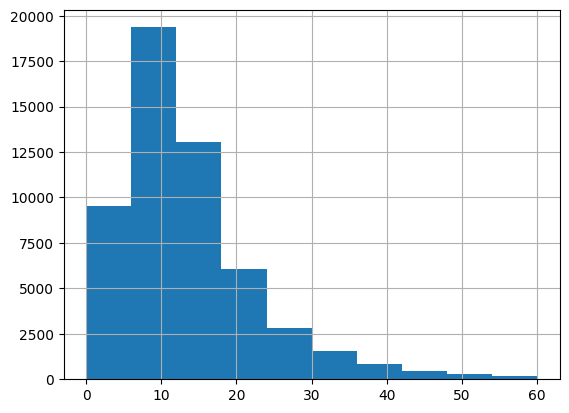

In [220]:
mar_data.duration_min.hist()

In [7]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [8]:
mar_data.shape

(54135, 21)

In [9]:
train_data = mar_data[:27000]
val_data = mar_data[27000:]

In [10]:
model = LinearRegression()

In [11]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [12]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [13]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [14]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.7144874783364425
3.721771823895028


# Dump model and reference data

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [16]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [17]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [18]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5),
    ColumnCorrelationsMetric(column_name="fare_amount")
]
)

In [19]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [ ]:
report.show(mode='inline')

In [20]:
result = report.as_dict()

In [21]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': np.float64(0.022945052836990307),
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-110.34815622352964,
       -84.99003030033938,
       -59.63190437714912,
       -34.273778453958855,
       -8.915652530768597,
       16.44247339242166,
       41.80059931561193,
       67.15872523880218,
       92.51685116199245,
       117.87497708518272,
       143.23310300837298],
      'y': [1.4532924587096125e-06,
       0.0,
       0.0,
       2.906584917419225e-06,
       0.031164403484568927,
       0.007907364267838998,
       0.00031100458616385723,
       3.923889638515952e-05,
       2.9065849174192234e-06,
       5.81316983483845e-06]}},
    'reference': {'small_distribution': {'x': [-61.62016826742817,
       -44.723583467749094,
       -27.8269986

In [22]:
#prediction drift
float(result['metrics'][0]['result']['drift_score'])

0.022945052836990307

In [23]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [24]:
#share of missing values
float(result['metrics'][2]['result']['current']['share_of_missing_values'])

0.04545957083270516

In [25]:
# Curent quantile 0.5 value for 'fare_amount' column
float(result['metrics'][3]['result']['current']['value'])

13.5

In [26]:
# Pearson correlation between 'fare_amount' and 'trip_distance' columns
float(result['metrics'][4]['result']['current']['pearson']['values']['y'][1])

0.7406636594689648

In [304]:
fare_amount = []

for i in range(1,31):
    regular_report = Report(
        metrics=[
            ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    
    result = regular_report.as_dict()
    #print(f"2024-03-{i:02} - {result['metrics'][0]['result']['current']['value']}")
    fare_amount.append(result['metrics'][0]['result']['current']['value'])

print(f"\nMaximum value of daily metric quantile = 0.5 on the 'fare_amount' during March 2024: {max(fare_amount)}")


Maximum value of daily metric quantile = 0.5 on the 'fare_amount' during March 2024: 14.2


# Evidently Dashboard

In [40]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [77]:
ws = Workspace("workspace")

In [78]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

Project(id=UUID('02e2318f-1a02-4e77-b902-a6ff2a36ba34'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 24, 13, 42, 55, 821420))

In [ ]:
for i in range(1,31):
    regular_report = Report(
        metrics=[
            DataQualityPreset(),
            ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    
    ws.add_report(project.id, regular_report)


In [80]:
result = regular_report.as_dict()

In [81]:
result

{'metrics': [{'metric': 'DatasetSummaryMetric',
   'result': {'almost_duplicated_threshold': 0.95,
    'current': {'target': None,
     'prediction': None,
     'date_column': None,
     'id_column': None,
     'number_of_columns': 21,
     'number_of_rows': 1483,
     'number_of_missing_values': 1483,
     'number_of_categorical_columns': 2,
     'number_of_numeric_columns': 4,
     'number_of_text_columns': 0,
     'number_of_datetime_columns': 2,
     'number_of_constant_columns': 1,
     'number_of_almost_constant_columns': 3,
     'number_of_duplicated_columns': 0,
     'number_of_almost_duplicated_columns': 0,
     'number_of_empty_rows': 0,
     'number_of_empty_columns': 1,
     'number_of_duplicated_rows': 0,
     'nans_by_columns': {'VendorID': 0,
      'lpep_pickup_datetime': 0,
      'lpep_dropoff_datetime': 0,
      'store_and_fwd_flag': 0,
      'RatecodeID': 0,
      'PULocationID': 0,
      'DOLocationID': 0,
      'passenger_count': 0,
      'trip_distance': 0,
      '

In [ ]:
regular_report.show(mode='inline')

In [86]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Rows",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Curent quantile 0.5 value for 'fare_amount' column",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

Project(id=UUID('02e2318f-1a02-4e77-b902-a6ff2a36ba34'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('3f70a229-0561-4adb-b0e5-c559254afa64'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('e6a4e3ee-be6d-4fba-9245-90b5a206d147'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(

In [ ]:
#fare_amount = []
#float(result['metrics'][4]['result']['current']['pearson']['values']['y'][1])

for i in range(1,31):
    regular_report2 = Report(
        metrics=[
            ColumnCorrelationsMetric(column_name="fare_amount")
        ],
        timestamp=datetime.datetime(2024,3,i)
    )

    regular_report2.run(reference_data=None,
                    current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(f'2024-03-{i:02}', f'2024-03-{i+1:02}', inclusive="left")],
                    column_mapping=column_mapping)
    
    result2 = regular_report2.as_dict()
    
    print(f"2024-03-{i:02} - {result2['metrics'][0]['result']['current']['pearson']['values']['y'][1]}")
    

#print(f"\nMaximum value of daily metric quantile = 0.5 on the 'fare_amount' during March 2024: {max(fare_amount)}")
#result2

In [ ]:
#share of number_of_rows
float(result['metrics'][2]['result']['current']['number_of_rows'])